# Feature Engineering

Este notebook tem como objetivo preparar o conjunto de dados para a etapa de modelagem preditiva, realizando transformações necessárias nas variáveis, com base nos insights obtidos na análise exploratória. As decisões adotadas visam aumentar a robustez estatística, reduzir ruído e preservar o significado semântico das variáveis.


In [74]:
# Importação do arquivo tratado no EDA (Analise Exploratória de Dados)

from pathlib import Path
import pandas as pd

base = Path(r"C:\projetos\fase4")

df_fe_obesidade = pd.read_csv(
    base / "data" / "processed" / "obesity_processed_eda.csv"
)

df_fe_obesidade.shape



(2084, 18)

In [75]:
# Verificação rápidade de duplicidades e valores nulos

print("Duplicados:", df_fe_obesidade.duplicated().sum())
print("Nulos:", df_fe_obesidade.isna().sum().sum())


Duplicados: 0
Nulos: 0


In [76]:
# Realiza cópia do DF para trabalhar e não sujar o arquivo carregado

df_model = df_fe_obesidade.copy()

df_model.shape


(2084, 18)

In [77]:
df_model.head()

,sexo,idade,altura,peso,historico_familiar,ingere_alim_calorico,ingere_vegetais,qtd_refeicao_principal,come_entre_refeicao,fumante,consumo_agua_litro,monitora_calorias,freq_atividade_fisica,tempo_uso_eletronico,frequencia_consumo_alcool,meio_de_transporte,nivel_obesidade,freq_ativ_fisica_texto
0,Feminino,21.0,1.62,64.0,Sim,Não,2.0,3.0,Às Vezes,Não,2.0,Não,0.0,1.0,Não,Transporte Público,Peso Normal,Nenhuma atividade
1,Feminino,21.0,1.52,56.0,Sim,Não,3.0,3.0,Às Vezes,Sim,3.0,Sim,3.0,0.0,Às Vezes,Transporte Público,Peso Normal,5x ou mais
2,Masculino,23.0,1.80,77.0,Sim,Não,2.0,3.0,Às Vezes,Não,2.0,Não,2.0,1.0,Frequentemente,Transporte Público,Peso Normal,3–4x por semana
3,Masculino,27.0,1.80,87.0,Não,Não,3.0,3.0,Às Vezes,Não,2.0,Não,2.0,0.0,Frequentemente,A Pé,Sobrepeso Nível I,3–4x por semana
4,Masculino,22.0,1.78,89.8,Não,Não,2.0,1.0,Às Vezes,Não,2.0,Não,0.0,0.0,Às Vezes,Transporte Público,Sobrepeso Nível II,Nenhuma atividade


In [78]:
# Excluir a coluna de frequencia de atividade física em texto, pois já temos ela em formato númerico

df_model = df_model.drop(columns=["freq_ativ_fisica_texto"])


In [79]:
# Tratar classes raras (decisões do EDA) - Frequência de consumo de álcool
# Sempre → agrupar em Frequentemente

df_model["frequencia_consumo_alcool"] = (
    df_model["frequencia_consumo_alcool"]
    .replace({"Sempre": "Frequentemente"})
)



In [80]:
# Tratar classes raras (decisões do EDA) - Meio de transporte
# Realizar Agrupamento semântico e estatístico: Motorizado e Não Motorizado

df_model["meio_de_transporte"] = df_model["meio_de_transporte"].replace({
    "Carro": "Motorizado",
    "Moto": "Motorizado",
    "Transporte Público": "Motorizado",
    "A Pé": "Nao_Motorizado",
    "Bicicleta": "Nao_Motorizado"
})



In [81]:
# Tratar classes raras (decisões do EDA) - Comer entre refeições
# Realizar Agrupamento por intensidade: Baixa, média, alta

df_model["come_entre_refeicao"] = df_model["come_entre_refeicao"].replace({
    "Não": "Baixa",
    "Às Vezes": "Media",
    "Frequentemente": "Alta",
    "Sempre": "Alta"
})


In [82]:
df_model.head()

,sexo,idade,altura,peso,historico_familiar,ingere_alim_calorico,ingere_vegetais,qtd_refeicao_principal,come_entre_refeicao,fumante,consumo_agua_litro,monitora_calorias,freq_atividade_fisica,tempo_uso_eletronico,frequencia_consumo_alcool,meio_de_transporte,nivel_obesidade
0,Feminino,21.0,1.62,64.0,Sim,Não,2.0,3.0,Media,Não,2.0,Não,0.0,1.0,Não,Motorizado,Peso Normal
1,Feminino,21.0,1.52,56.0,Sim,Não,3.0,3.0,Media,Sim,3.0,Sim,3.0,0.0,Às Vezes,Motorizado,Peso Normal
2,Masculino,23.0,1.80,77.0,Sim,Não,2.0,3.0,Media,Não,2.0,Não,2.0,1.0,Frequentemente,Motorizado,Peso Normal
3,Masculino,27.0,1.80,87.0,Não,Não,3.0,3.0,Media,Não,2.0,Não,2.0,0.0,Frequentemente,Nao_Motorizado,Sobrepeso Nível I
4,Masculino,22.0,1.78,89.8,Não,Não,2.0,1.0,Media,Não,2.0,Não,0.0,0.0,Às Vezes,Motorizado,Sobrepeso Nível II


In [83]:
# Codificação de variáveis binárias (converte texto em números nas colunas que só possuem duas opções - sexo, historico_familiar, ingere_alim_calorico, fumante e monitora_calorias)
# Modeslo de ML não trabalham com texto diretamente Então é necessário “codificar” as respostas para números

# Dicionário
bin_map = {
    "Sim": 1,
    "Não": 0,
    "Masculino": 1,
    "Feminino": 0,
    "Motorizado": 1,
    "Nao_Motorizado": 0
}

# Colunas afetadas
cols_binarias = [
    "sexo",
    "historico_familiar",
    "ingere_alim_calorico",
    "fumante",
    "monitora_calorias",
    "meio_de_transporte"
]

for c in cols_binarias:
    df_model[c] = df_model[c].map(bin_map)


In [85]:
df_model.head()

,sexo,idade,altura,peso,historico_familiar,ingere_alim_calorico,ingere_vegetais,qtd_refeicao_principal,come_entre_refeicao,fumante,consumo_agua_litro,monitora_calorias,freq_atividade_fisica,tempo_uso_eletronico,frequencia_consumo_alcool,meio_de_transporte,nivel_obesidade
0,0,21.0,1.62,64.0,1,0,2.0,3.0,Media,0,2.0,0,0.0,1.0,Não,1,Peso Normal
1,0,21.0,1.52,56.0,1,0,3.0,3.0,Media,1,3.0,1,3.0,0.0,Às Vezes,1,Peso Normal
2,1,23.0,1.80,77.0,1,0,2.0,3.0,Media,0,2.0,0,2.0,1.0,Frequentemente,1,Peso Normal
3,1,27.0,1.80,87.0,0,0,3.0,3.0,Media,0,2.0,0,2.0,0.0,Frequentemente,0,Sobrepeso Nível I
4,1,22.0,1.78,89.8,0,0,2.0,1.0,Media,0,2.0,0,0.0,0.0,Às Vezes,1,Sobrepeso Nível II


In [86]:
# Codificação de variáveis ordinais

alcool_ord = {"Não": 0, "Às Vezes": 1, "Frequentemente": 2}
df_model["frequencia_consumo_alcool"] = (
    df_model["frequencia_consumo_alcool"].map(alcool_ord)
)

come_ord = {"Baixa": 0, "Media": 1, "Alta": 2}
df_model["come_entre_refeicao"] = (
    df_model["come_entre_refeicao"].map(come_ord)
)


In [88]:
# Checagem de integridade pós-transformação

print("Shape:", df_model.shape)
print("Nulos totais:", df_model.isna().sum().sum())
print("Duplicados:", df_model.duplicated().sum())

df_model.info()
df_model.head()


Shape: (2084, 17)
Nulos totais: 0
Duplicados: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sexo                       2084 non-null   int64  
 1   idade                      2084 non-null   float64
 2   altura                     2084 non-null   float64
 3   peso                       2084 non-null   float64
 4   historico_familiar         2084 non-null   int64  
 5   ingere_alim_calorico       2084 non-null   int64  
 6   ingere_vegetais            2084 non-null   float64
 7   qtd_refeicao_principal     2084 non-null   float64
 8   come_entre_refeicao        2084 non-null   int64  
 9   fumante                    2084 non-null   int64  
 10  consumo_agua_litro         2084 non-null   float64
 11  monitora_calorias          2084 non-null   int64  
 12  freq_atividade_fisica      2084 non-null   float64
 13  

,sexo,idade,altura,peso,historico_familiar,ingere_alim_calorico,ingere_vegetais,qtd_refeicao_principal,come_entre_refeicao,fumante,consumo_agua_litro,monitora_calorias,freq_atividade_fisica,tempo_uso_eletronico,frequencia_consumo_alcool,meio_de_transporte,nivel_obesidade
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,1,Peso Normal
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,1,Peso Normal
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,1,Peso Normal
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,0,Sobrepeso Nível I
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,1,Sobrepeso Nível II


In [92]:
# Ajuste de algumas colunas de float64 para int64

cols_float = [
    "ingere_vegetais",
    "qtd_refeicao_principal",
    "consumo_agua_litro",
    "freq_atividade_fisica",
    "tempo_uso_eletronico"
]

df_model[cols_float] = df_model[cols_float].astype(int)

# Checagem de integridade pós-transformação

df_model.info()
df_model.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sexo                       2084 non-null   int64  
 1   idade                      2084 non-null   float64
 2   altura                     2084 non-null   float64
 3   peso                       2084 non-null   float64
 4   historico_familiar         2084 non-null   int64  
 5   ingere_alim_calorico       2084 non-null   int64  
 6   ingere_vegetais            2084 non-null   int64  
 7   qtd_refeicao_principal     2084 non-null   int64  
 8   come_entre_refeicao        2084 non-null   int64  
 9   fumante                    2084 non-null   int64  
 10  consumo_agua_litro         2084 non-null   int64  
 11  monitora_calorias          2084 non-null   int64  
 12  freq_atividade_fisica      2084 non-null   int64  
 13  tempo_uso_eletronico       2084 non-null   int64

,sexo,idade,altura,peso,historico_familiar,ingere_alim_calorico,ingere_vegetais,qtd_refeicao_principal,come_entre_refeicao,fumante,consumo_agua_litro,monitora_calorias,freq_atividade_fisica,tempo_uso_eletronico,frequencia_consumo_alcool,meio_de_transporte,nivel_obesidade
0,0,21.0,1.62,64.0,1,0,2,3,1,0,2,0,0,1,0,1,Peso Normal
1,0,21.0,1.52,56.0,1,0,3,3,1,1,3,1,3,0,1,1,Peso Normal
2,1,23.0,1.80,77.0,1,0,2,3,1,0,2,0,2,1,2,1,Peso Normal
3,1,27.0,1.80,87.0,0,0,3,3,1,0,2,0,2,0,2,0,Sobrepeso Nível I
4,1,22.0,1.78,89.8,0,0,2,1,1,0,2,0,0,0,1,1,Sobrepeso Nível II


## Separar target e features

In [104]:
# Separar a minha variável alvo das features ( Aqui sem codificar o target, pois a decisão fica no modelo)

target = "nivel_obesidade"

X = df_model.drop(columns=[target])
y = df_model[target]

X.shape, y.shape


((2084, 16), (2084,))

In [105]:
X.head()

,sexo,idade,altura,peso,historico_familiar,ingere_alim_calorico,ingere_vegetais,qtd_refeicao_principal,come_entre_refeicao,fumante,consumo_agua_litro,monitora_calorias,freq_atividade_fisica,tempo_uso_eletronico,frequencia_consumo_alcool,meio_de_transporte
0,0,21.0,1.62,64.0,1,0,2,3,1,0,2,0,0,1,0,1
1,0,21.0,1.52,56.0,1,0,3,3,1,1,3,1,3,0,1,1
2,1,23.0,1.80,77.0,1,0,2,3,1,0,2,0,2,1,2,1
3,1,27.0,1.80,87.0,0,0,3,3,1,0,2,0,2,0,2,0
4,1,22.0,1.78,89.8,0,0,2,1,1,0,2,0,0,0,1,1


In [106]:
y.head(10)

0           Peso Normal
1           Peso Normal
2           Peso Normal
3     Sobrepeso Nível I
4    Sobrepeso Nível II
5           Peso Normal
6           Peso Normal
7           Peso Normal
8           Peso Normal
9           Peso Normal
Name: nivel_obesidade, dtype: object

In [107]:
# Salvar base feature-ready

arquivo_features = base / "data" / "features" / "obesidade_features.csv"
arquivo_features.parent.mkdir(parents=True, exist_ok=True)

df_model.to_csv(arquivo_features, index=False)

print("Arquivo de features salvo em:", arquivo_features)


Arquivo de features salvo em: C:\projetos\fase4\data\features\obesidade_features.csv


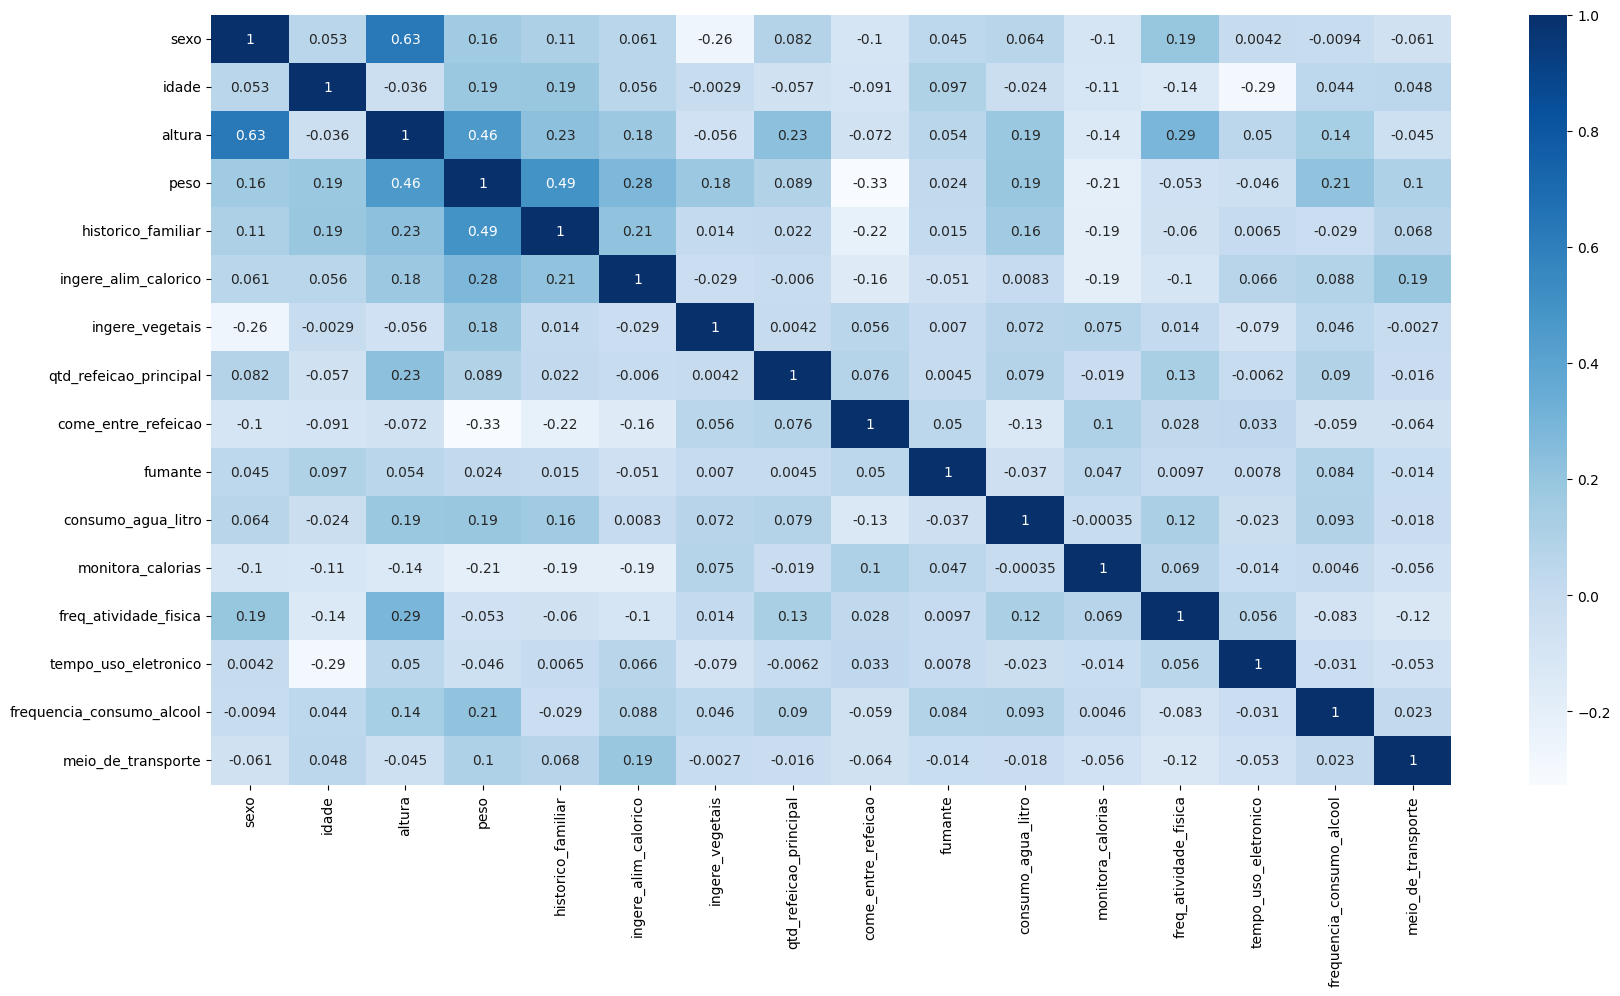

In [113]:
# Correlação das features

import matplotlib.pyplot as plt
import seaborn as sns

corr = X.corr()

plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True, cmap="Blues")
plt.show()


A figura apresenta a correlação de Pearson entre as variáveis explicativas (features), sem a inclusão do target, procedimento adotado corretamente nesta etapa.

Valores de correlação próximos de 1 ou -1 indicam correlação forte, enquanto valores próximos de 0 indicam fraca ou nenhuma correlação. Como regra prática, considera-se correlação forte quando |corr| ≥ 0,7, moderada quando 0,3 ≤ |corr| < 0,7 e fraca quando |corr| < 0,3.

Observa-se que não há correlações fortes entre as features, indicando ausência de multicolinearidade severa no conjunto de dados. Dessa forma, todas as variáveis podem ser mantidas para a etapa de modelagem.

Algumas correlações apresentam valores muito baixos ou aparentemente inconsistentes, o que é esperado, pois parte das variáveis é binária (0 ou 1) ou ordinal com poucos níveis. Nesses casos, a correlação de Pearson não é a métrica mais adequada, devendo os resultados serem interpretados com cautela.


# Modelagem
## Separar treino e teste
Regra padrão: 80% treino / 20% teste, estratificando pelo target (importante em multiclasses).


In [117]:
from sklearn.model_selection 
import train_test_split

# O X e o y já foram definidos acima, vou deixar apenas para validação do bloco

target = "nivel_obesidade"

X = df_model.drop(columns=[target])
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape



((1667, 16), (417, 16))

In [118]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("Classes do target:")
print(le.classes_)


Classes do target:
['Obesidade Grau I' 'Obesidade Grau II' 'Obesidade Grau III'
 'Peso Insuficiente' 'Peso Normal' 'Sobrepeso Nível I'
 'Sobrepeso Nível II']


In [119]:
# Função de treino + avaliação

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def rodar_modelo(nome, modelo, X_train, y_train, X_test, y_test, class_names=None):
    pipe = Pipeline([
        ("model", modelo)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\nModelo: {nome}")
    print("Acurácia:", round(acc, 4))

    print("\nRelatório de classificação:")
    if class_names is None:
        print(classification_report(y_test, y_pred))
    else:
        print(classification_report(y_test, y_pred, target_names=class_names))

    print("Matriz de confusão:")
    print(confusion_matrix(y_test, y_pred))

    return pipe, y_pred, acc



In [120]:
# Roda a função com o Algoritmo / modelo: Decision Tree

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    random_state=42,
    max_depth=5
)

pipe_dt, y_pred_dt, acc_dt = rodar_modelo(
    "Decision Tree (baseline)",
    dt,
    X_train, y_train_enc,
    X_test, y_test_enc,
    class_names=le.classes_
)



Modelo: Decision Tree (baseline)
Acurácia: 0.8177

Relatório de classificação:
                    precision    recall  f1-score   support

  Obesidade Grau I       0.79      0.89      0.84        70
 Obesidade Grau II       0.97      0.95      0.96        60
Obesidade Grau III       1.00      1.00      1.00        65
 Peso Insuficiente       0.94      0.94      0.94        53
       Peso Normal       0.83      0.61      0.70        56
 Sobrepeso Nível I       0.63      0.49      0.55        55
Sobrepeso Nível II       0.59      0.79      0.68        58

          accuracy                           0.82       417
         macro avg       0.82      0.81      0.81       417
      weighted avg       0.82      0.82      0.82       417

Matriz de confusão:
[[62  2  0  0  0  1  5]
 [ 3 57  0  0  0  0  0]
 [ 0  0 65  0  0  0  0]
 [ 0  0  0 50  3  0  0]
 [ 0  0  0  3 34 15  4]
 [ 1  0  0  0  4 27 23]
 [12  0  0  0  0  0 46]]


In [121]:
# Roda a função com o Algoritmo / modelo: Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    random_state=42,
    n_estimators=500,
    n_jobs=-1,
    class_weight="balanced"
)

pipe_rf, y_pred_rf, acc_rf = rodar_modelo(
    "Random Forest",
    rf,
    X_train, y_train_enc,
    X_test, y_test_enc,
    class_names=le.classes_
)



Modelo: Random Forest
Acurácia: 0.9544

Relatório de classificação:
                    precision    recall  f1-score   support

  Obesidade Grau I       0.99      0.96      0.97        70
 Obesidade Grau II       1.00      0.98      0.99        60
Obesidade Grau III       1.00      1.00      1.00        65
 Peso Insuficiente       0.98      1.00      0.99        53
       Peso Normal       0.85      0.91      0.88        56
 Sobrepeso Nível I       0.88      0.91      0.89        55
Sobrepeso Nível II       0.98      0.91      0.95        58

          accuracy                           0.95       417
         macro avg       0.95      0.95      0.95       417
      weighted avg       0.96      0.95      0.95       417

Matriz de confusão:
[[67  0  0  0  2  0  1]
 [ 1 59  0  0  0  0  0]
 [ 0  0 65  0  0  0  0]
 [ 0  0  0 53  0  0  0]
 [ 0  0  0  1 51  4  0]
 [ 0  0  0  0  5 50  0]
 [ 0  0  0  0  2  3 53]]


In [122]:
# Roda a função com o Algoritmo / modelo: Gradient Boosting (sklearn)

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    random_state=42
)

pipe_gb, y_pred_gb, acc_gb = rodar_modelo(
    "Gradient Boosting",
    gb,
    X_train, y_train_enc,
    X_test, y_test_enc,
    class_names=le.classes_
)



Modelo: Gradient Boosting
Acurácia: 0.9688

Relatório de classificação:
                    precision    recall  f1-score   support

  Obesidade Grau I       0.97      0.99      0.98        70
 Obesidade Grau II       0.98      0.97      0.97        60
Obesidade Grau III       1.00      1.00      1.00        65
 Peso Insuficiente       0.98      0.98      0.98        53
       Peso Normal       0.90      0.96      0.93        56
 Sobrepeso Nível I       0.98      0.87      0.92        55
Sobrepeso Nível II       0.97      1.00      0.98        58

          accuracy                           0.97       417
         macro avg       0.97      0.97      0.97       417
      weighted avg       0.97      0.97      0.97       417

Matriz de confusão:
[[69  1  0  0  0  0  0]
 [ 2 58  0  0  0  0  0]
 [ 0  0 65  0  0  0  0]
 [ 0  0  0 52  1  0  0]
 [ 0  0  0  1 54  1  0]
 [ 0  0  0  0  5 48  2]
 [ 0  0  0  0  0  0 58]]


In [123]:
# Roda a função com o Algoritmo / modelo: Logistic Regression (com scaler)
# Aqui usamos pipeline com scaler (faz sentido pra modelo linear).


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=3000, random_state=42))
])

pipe_lr.fit(X_train, y_train_enc)
y_pred_lr = pipe_lr.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("\nModelo: Logistic Regression")
print("Acurácia:", round(accuracy_score(y_test_enc, y_pred_lr), 4))
print("\nRelatório de classificação:")
print(classification_report(y_test_enc, y_pred_lr, target_names=le.classes_))
print("Matriz de confusão:")
print(confusion_matrix(y_test_enc, y_pred_lr))



Modelo: Logistic Regression
Acurácia: 0.8849

Relatório de classificação:
                    precision    recall  f1-score   support

  Obesidade Grau I       0.88      0.91      0.90        70
 Obesidade Grau II       0.94      0.98      0.96        60
Obesidade Grau III       1.00      0.98      0.99        65
 Peso Insuficiente       0.93      0.94      0.93        53
       Peso Normal       0.80      0.80      0.80        56
 Sobrepeso Nível I       0.79      0.80      0.79        55
Sobrepeso Nível II       0.84      0.74      0.79        58

          accuracy                           0.88       417
         macro avg       0.88      0.88      0.88       417
      weighted avg       0.88      0.88      0.88       417

Matriz de confusão:
[[64  4  0  0  0  1  1]
 [ 1 59  0  0  0  0  0]
 [ 1  0 64  0  0  0  0]
 [ 0  0  0 50  3  0  0]
 [ 0  0  0  4 45  5  2]
 [ 0  0  0  0  6 44  5]
 [ 7  0  0  0  2  6 43]]


In [125]:
import pandas as pd

comparacao = pd.DataFrame([
    {"Modelo": "Decision Tree", "Acuracia": 0.8177, "Macro_F1": 0.81},
    {"Modelo": "Logistic Regression", "Acuracia": 0.8849, "Macro_F1": 0.88},
    {"Modelo": "Random Forest", "Acuracia": 0.9544, "Macro_F1": 0.95},
    {"Modelo": "Gradient Boosting", "Acuracia": 0.9688, "Macro_F1": 0.97},
])

comparacao.sort_values("Acuracia", ascending=False)



,Modelo,Acuracia,Macro_F1
3,Gradient Boosting,0.9688,0.97
2,Random Forest,0.9544,0.95
1,Logistic Regression,0.8849,0.88
0,Decision Tree,0.8177,0.81


Foram avaliados diferentes modelos de machine learning para a classificação do nível de obesidade, incluindo Decision Tree, Logistic Regression, Random Forest e Gradient Boosting. O modelo de árvore de decisão foi utilizado como baseline, apresentando desempenho inferior em relação aos demais, conforme esperado.

Os modelos ensemble apresentaram ganhos significativos de desempenho. O Random Forest demonstrou excelente equilíbrio entre precisão, recall e estabilidade entre as classes, enquanto o Gradient Boosting obteve o melhor desempenho global, com maior acurácia e F1-score macro.

Diante dos resultados, os modelos Random Forest e Gradient Boosting foram selecionados como modelos finais do estudo, sendo utilizados de forma complementar. O Random Forest foi adotado por sua robustez e estabilidade, enquanto o Gradient Boosting foi empregado por apresentar o melhor desempenho preditivo global, permitindo uma análise comparativa mais consistente dos resultados.


In [126]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc
)
from sklearn.preprocessing import label_binarize


def roda_modelo(nome, modelo, X_train, y_train, X_test, y_test, class_names):
    """
    Treina o modelo e exibe:
    - Matriz de confusão normalizada (gráfico)
    - Classification report (texto)
    - ROC curve macro-average (gráfico) para multiclasse (OvR)
    """
    pipe = Pipeline([("model", modelo)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # ====== Métricas texto ======
    acc = accuracy_score(y_test, y_pred)
    print(f"\nModelo: {nome}")
    print("Acurácia:", round(acc, 4))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # ====== Matriz de confusão normalizada (gráfico) ======
    cm = confusion_matrix(y_test, y_pred, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(9, 7))
    disp.plot(values_format=".2f", cmap="Blues")
    plt.title("Matriz de Confusão (Normalizada)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # ====== ROC Curve (multiclasse OvR) ======
    # Precisamos de scores: predict_proba ou decision_function
    y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

    y_score = None
    model_fitted = pipe.named_steps["model"]

    if hasattr(pipe, "predict_proba"):
        y_score = pipe.predict_proba(X_test)
    elif hasattr(model_fitted, "decision_function"):
        y_score = model_fitted.decision_function(X_test)

        # se decision_function vier (n_samples,) (binário), ajusta
        if y_score.ndim == 1:
            y_score = y_score.reshape(-1, 1)

    if y_score is None:
        print("\nROC Curve: modelo não fornece predict_proba nem decision_function. Pulando ROC.")
        return pipe, y_pred, acc

    # Macro-average ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # média macro: junta todos os pontos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(class_names)

    macro_auc = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(7, 5))
    plt.plot(all_fpr, mean_tpr, label=f"ROC Macro-average (AUC = {macro_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclasse - Macro Average)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return pipe, y_pred, acc, macro_auc



Modelo: Random Forest
Acurácia: 0.952

Classification Report:
                    precision    recall  f1-score   support

  Obesidade Grau I       0.99      0.97      0.98        70
 Obesidade Grau II       1.00      0.98      0.99        60
Obesidade Grau III       1.00      1.00      1.00        65
 Peso Insuficiente       0.98      1.00      0.99        53
       Peso Normal       0.86      0.91      0.89        56
 Sobrepeso Nível I       0.86      0.89      0.88        55
Sobrepeso Nível II       0.96      0.90      0.93        58

          accuracy                           0.95       417
         macro avg       0.95      0.95      0.95       417
      weighted avg       0.95      0.95      0.95       417



<Figure size 900x700 with 0 Axes>

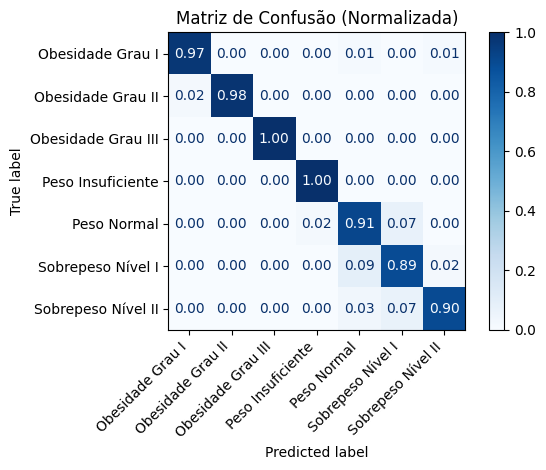

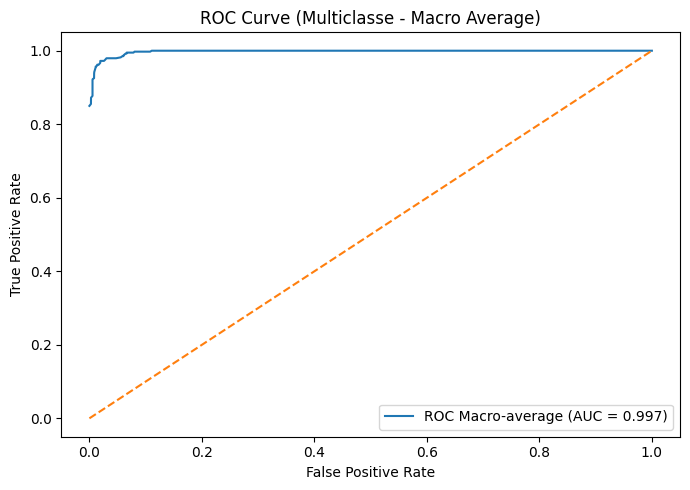

In [128]:
from sklearn.ensemble import RandomForestClassifier

modelo_rf = RandomForestClassifier(
    random_state=42,
    n_estimators=500,
    n_jobs=-1
)

pipe_rf, ypred_rf, acc_rf, auc_rf = roda_modelo(
    "Random Forest",
    modelo_rf,
    X_train, y_train_enc,
    X_test, y_test_enc,
    class_names=le.classes_
)



Modelo: Gradient Boosting
Acurácia: 0.9688

Classification Report:
                    precision    recall  f1-score   support

  Obesidade Grau I       0.97      0.99      0.98        70
 Obesidade Grau II       0.98      0.97      0.97        60
Obesidade Grau III       1.00      1.00      1.00        65
 Peso Insuficiente       0.98      0.98      0.98        53
       Peso Normal       0.90      0.96      0.93        56
 Sobrepeso Nível I       0.98      0.87      0.92        55
Sobrepeso Nível II       0.97      1.00      0.98        58

          accuracy                           0.97       417
         macro avg       0.97      0.97      0.97       417
      weighted avg       0.97      0.97      0.97       417



<Figure size 900x700 with 0 Axes>

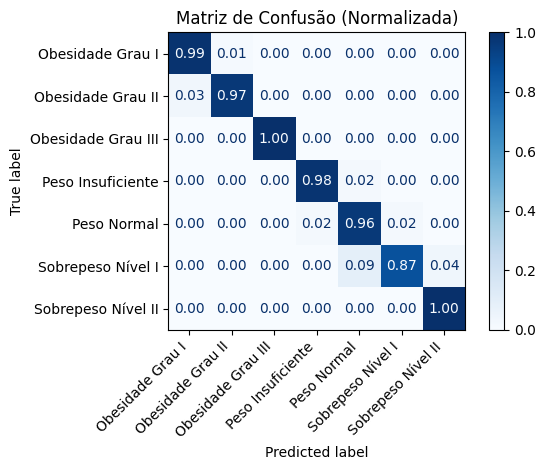

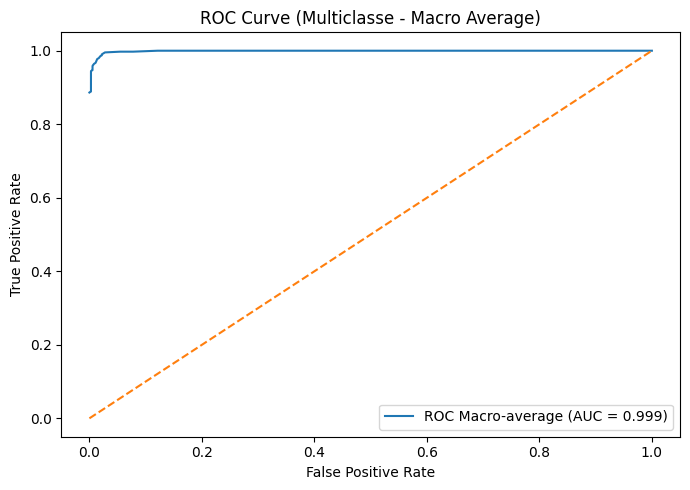

In [129]:
from sklearn.ensemble import GradientBoostingClassifier

modelo_gb = GradientBoostingClassifier(random_state=42)

pipe_gb, ypred_gb, acc_gb, auc_gb = roda_modelo(
    "Gradient Boosting",
    modelo_gb,
    X_train, y_train_enc,
    X_test, y_test_enc,
    class_names=le.classes_
)


In [130]:
from pathlib import Path
import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Base do projeto
base = Path(r"C:\projetos\fase4")

# Target
target = "nivel_obesidade"

# X e y (usando df_model já pronto do feature engineering)
X_full = df_model.drop(columns=[target]).copy()
y_full = df_model[target].copy()

# Encoder do target (rótulos -> números)
le_final = LabelEncoder()
y_full_enc = le_final.fit_transform(y_full)

# Garantir pasta models
models_dir = base / "models"
models_dir.mkdir(parents=True, exist_ok=True)

# (Recomendado) Guardar os mapeamentos usados no FE para replicar no app
mapeamentos = {
    "sexo": {"Feminino": 0, "Masculino": 1},
    "sim_nao": {"Não": 0, "Sim": 1},
    "come_entre_refeicao": {"Baixa": 0, "Media": 1, "Alta": 2},
    "frequencia_consumo_alcool": {"Não": 0, "Às Vezes": 1, "Frequentemente": 2},
    "meio_de_transporte": {"Nao_Motorizado": 0, "Motorizado": 1},
}

# =========================
# Modelo 1: Random Forest
# =========================
rf_final = RandomForestClassifier(
    random_state=42,
    n_estimators=500,
    n_jobs=-1
)

pipe_rf_final = Pipeline([
    ("model", rf_final)
])

pipe_rf_final.fit(X_full, y_full_enc)

artefato_rf = {
    "model_name": "RandomForestClassifier",
    "pipeline": pipe_rf_final,
    "classes": le_final.classes_,
    "feature_columns": list(X_full.columns),
    "mapeamentos": mapeamentos
}

joblib.dump(artefato_rf, models_dir / "modelo_random_forest.joblib")


# ============================
# Modelo 2: Gradient Boosting
# ============================
gb_final = GradientBoostingClassifier(
    random_state=42
)

pipe_gb_final = Pipeline([
    ("model", gb_final)
])

pipe_gb_final.fit(X_full, y_full_enc)

artefato_gb = {
    "model_name": "GradientBoostingClassifier",
    "pipeline": pipe_gb_final,
    "classes": le_final.classes_,
    "feature_columns": list(X_full.columns),
    "mapeamentos": mapeamentos
}

joblib.dump(artefato_gb, models_dir / "modelo_gradient_boosting.joblib")

print("Salvo:")
print(models_dir / "modelo_random_forest.joblib")
print(models_dir / "modelo_gradient_boosting.joblib")


Salvo:
C:\projetos\fase4\models\modelo_random_forest.joblib
C:\projetos\fase4\models\modelo_gradient_boosting.joblib


In [131]:
import joblib

artefato_teste = joblib.load(models_dir / "modelo_gradient_boosting.joblib")
pipe_loaded = artefato_teste["pipeline"]
classes_loaded = artefato_teste["classes"]
cols_loaded = artefato_teste["feature_columns"]

pred = pipe_loaded.predict(X_full.iloc[[0]][cols_loaded])[0]
print("Teste OK — previsão:", classes_loaded[pred])


Teste OK — previsão: Peso Normal
